       name   datetime  temp  feelslike  humidity  precip  precipprob  \
0  Istanbul 2024-01-01  11.8       11.8     82.88     0.0           0   
1  Istanbul 2024-01-01  11.8       11.8     82.88     0.0           0   
2  Istanbul 2024-01-01  11.8       11.8     82.88     0.0           0   
3  Istanbul 2024-01-01  11.8       11.8     82.88     0.0           0   
4  Istanbul 2024-01-01  11.8       11.8     82.88     0.0           0   

  preciptype  windspeed  visibility  \
0        NaN        3.0         7.2   
1        NaN        3.0         7.2   
2        NaN        3.0         7.2   
3        NaN        3.0         7.2   
4        NaN        3.0         7.2   

                                         stations  _id  DATE_TIME  \
0  D8508,LTBA,17063099999,17064099999,17060099999    1 2024-01-01   
1  D8508,LTBA,17063099999,17064099999,17060099999    2 2024-01-01   
2  D8508,LTBA,17063099999,17064099999,17060099999    3 2024-01-01   
3  D8508,LTBA,17063099999,17064099999,17060099999 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


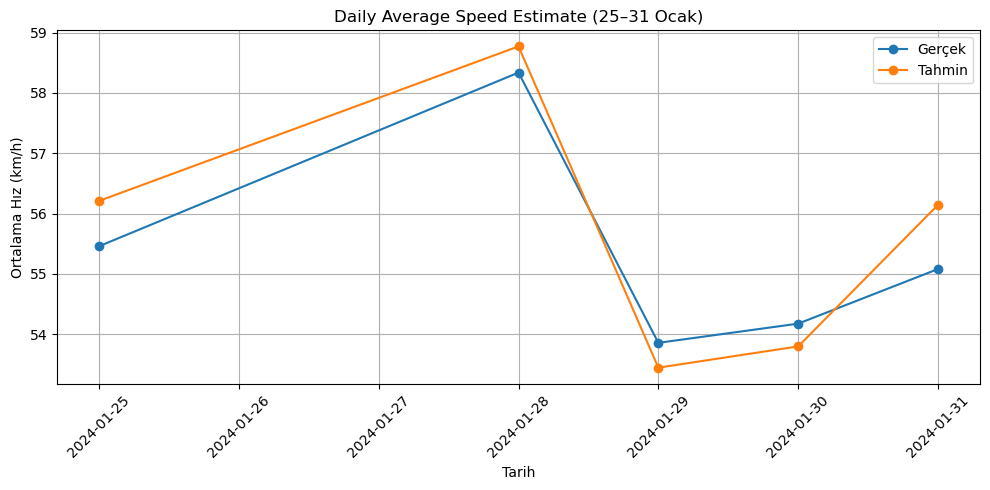

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Read files
hava_df = pd.read_excel("2024_ocak_ist_hava.xlsx")
trafik_df = pd.read_excel("2024_ocak_trafik_yogunlugu.xlsx")

# 2. Convert to datetime
hava_df["datetime"] = pd.to_datetime(hava_df["datetime"])
trafik_df["datetime"] = pd.to_datetime(trafik_df["DATE_TIME"])

# 3. Merge datasets
df = pd.merge(hava_df, trafik_df, on="datetime", how="inner")

# 4. Info
print(df.head())
print("Weather data rows:", len(hava_df))
print("Traffic data rows:", len(trafik_df))
print("Merged data rows:", len(df))

# 5. Descriptive stats
numeric_df = df.select_dtypes(include='number')
print(numeric_df.describe().transpose())


#Machine Learning Part
#Target = Average Speed 

# 1. 'datetime' sütunundan günlük tarih bilgisi oluştur
df["date"] = pd.to_datetime(df["datetime"].dt.date)

# 2. Etkileşimli değişkenleri oluştur (saatlik veride)
df["precip_x_vehicles"] = df["precip"] * df["NUMBER_OF_VEHICLES"]
df["visibility_x_maxspeed"] = df["visibility"] * df["MAXIMUM_SPEED"]

# 3. Günlük ortalamaları alınacak değişkenler
daily_features = [
    "AVERAGE_SPEED", "MAXIMUM_SPEED", "MINIMUM_SPEED", "NUMBER_OF_VEHICLES",
    "temp", "humidity", "precip", "windspeed", "visibility",
    "precip_x_vehicles", "visibility_x_maxspeed"
]

# 4. Günlük ortalama veri setini oluştur
daily_df = df.groupby("date")[daily_features].mean().reset_index()

# 5. 'date' sütununu datetime tipine çevir (dt özellikleri için zorunlu)
daily_df["date"] = pd.to_datetime(daily_df["date"])

# 6. Zaman temelli yeni özellikleri oluştur
daily_df["day_of_week"] = daily_df["date"].dt.dayofweek  # Pazartesi=0, Pazar=6
daily_df["is_weekend"] = (daily_df["day_of_week"] >= 5).astype(int)

# 7. Hedef ve bağımsız değişkenleri belirle
target_col = "AVERAGE_SPEED"
feature_cols = [
    "MAXIMUM_SPEED", "MINIMUM_SPEED", "NUMBER_OF_VEHICLES",
    "temp", "humidity", "precip", "windspeed", "visibility",
    "precip_x_vehicles", "visibility_x_maxspeed",
    "day_of_week", "is_weekend"
]

# 8. İlk 24 günü eğitim, son 7 günü test seti olarak ayır
train_df = daily_df[daily_df["date"] < "2024-01-25"]
test_df = daily_df[daily_df["date"] >= "2024-01-25"]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 9. Modeli oluştur ve eğit
model = LinearRegression()
model.fit(X_train, y_train)

# 10. Test verisinde tahmin yap
y_pred = model.predict(X_test)

# 11. Gerçek vs tahmin tabloyu oluştur
results_df = test_df[["date"]].copy()
results_df["Actual"] = y_test.values
results_df["Predicted"] = y_pred

# 12. Performans metriklerini hesapla
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Forecast Results (25-31 Ocak) ---")
print(results_df)
print("\nPerformans Metrikleri:")
print(f"R² skoru: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# 13. Tahminleri grafikle karşılaştır
plt.figure(figsize=(10, 5))
plt.plot(results_df["date"], results_df["Actual"], label="Gerçek", marker="o")
plt.plot(results_df["date"], results_df["Predicted"], label="Tahmin", marker="o")
plt.title("Daily Average Speed ​​Estimate (25–31 Ocak)")
plt.xlabel("Tarih")
plt.ylabel("Ortalama Hız (km/h)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

